# Import Packages

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

%matplotlib inline

In [2]:
#define SQL and pandas functions to speed up the queries
def run_query(query, db = 'chinook.db'):
    #takes a query and a database (default db is the one used here)
    #returns pd.Dataframe of the query
    with sqlite3.connect(db) as conn:
        return pd.read_sql(query, conn)

def run_command(query, db = 'chinook.db'):
    #takes a query and a database (default db is the one used here)
    #returns the sqlite3 result of the query
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        return conn.execute(query)

def show_tables(db = 'chinook.db'):
    #takes a database and returns all tables and views
    query = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(query, db)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Determine which genre sells the most in the US

    genre is in `name` in `genre`
    number of tracks sold is in `quantity` `invoice_line`
    these are joined through `track` at `genre_id` and `track_id`

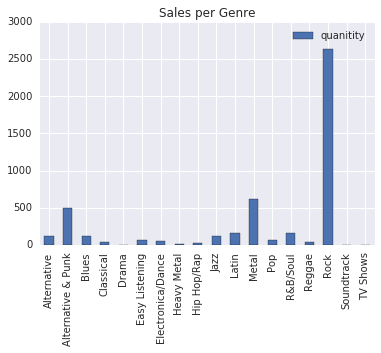

In [4]:
sales_per_genre_query = """
WITH
    track_quantity AS
    (
        SELECT
            track_id,
            SUM(quantity) quanitity
        FROM invoice_line
        GROUP BY track_id
    ), 
    genre_and_tracks AS
    (
        SELECT
            t.track_id,
            g.name genre
        FROM genre g
        INNER JOIN track t ON t.genre_id = g.genre_id
    )
    SELECT
        gt.genre,
        SUM(tq.quanitity) quanitity
    FROM genre_and_tracks gt
    INNER JOIN track_quantity tq ON tq.track_id = gt.track_id
    GROUP BY 1
    ORDER BY 1;
"""

sales_per_genre = run_query(sales_per_genre_query)
ax = sales_per_genre.plot(kind = 'bar', title = 'Sales per Genre')
sns.set_style('white')
ax.set_xticklabels(sales_per_genre['genre'].tolist())

# Determine which 3 bands to add to the library based on sales

| Artist Name | Genre |
|:---:|:---:|
| Regal | Hip-Hop |
| Red Tone | Punk | 
|Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

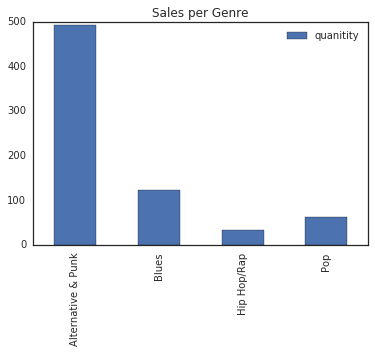

In [5]:
#delimited plot
genres = ["Alternative & Punk", "Blues", "Hip Hop/Rap", "Pop"]

ax = sales_per_genre.loc[sales_per_genre['genre'].isin(genres),].plot(kind = 'bar', title = 'Sales per Genre')
sns.set_style('white')
ax.set_xticklabels(sales_per_genre.loc[sales_per_genre['genre'].isin(genres),'genre'].tolist())

The bands selected sould be:

| Artist Name | Genre |
|:---:|:---:|
| Red Tone | Punk | 
|Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

These genres had the highest downloads of the four 

# Determine sales per employee


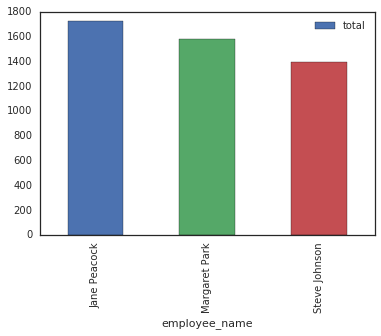

In [6]:
sales_rep_sales_query = """
WITH
    sales_per_customer AS
        (
            SELECT
                SUM(i.total) total,
                c.support_rep_id,
                MAX(i.invoice_date) last_sale
            FROM customer c
            INNER JOIN invoice i ON i.customer_id = c.customer_id
            GROUP BY support_rep_id
        )
SELECT
    (e.first_name || " " || e.last_name) employee_name,
    s.total,
    e.hire_date,
    s.last_sale,
    e.country,
    e.title
FROM employee e
INNER JOIN sales_per_customer s ON s.support_rep_id = e.employee_id
"""


sales_rep_sales = run_query(sales_rep_sales_query)

ax = sales_rep_sales.plot(kind = 'bar', x='employee_name', y='total')
ax.set_xticklabels(sales_rep_sales['employee_name'].tolist())
sns.set_style('white')

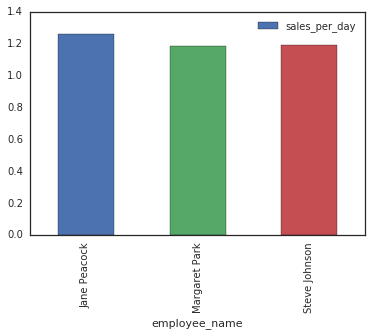

In [7]:
#since the time working may bias these numbers
#we have to control for days between the hire date and the last sale (overall)
sales_rep_sales['days_working'] = max(pd.to_datetime(sales_rep_sales['last_sale'])) - pd.to_datetime(sales_rep_sales['hire_date'])

sales_rep_sales['sales_per_day'] = sales_rep_sales['total'] / (sales_rep_sales['days_working'].dt.total_seconds() / (24*60*60))
ax = sales_rep_sales.plot(kind='bar', x = 'employee_name', y='sales_per_day')

ax.set_xticklabels(sales_rep_sales['employee_name'].tolist())
sns.set_style('white')

Employee with the most sales is Jane Peacook both over time and in total

# Purchases per country

In [8]:
purchases_per_country_query = """
WITH
customer_values AS 
    (
        SELECT
             c.customer_id,
             SUM(i.total) total_sales,
             COUNT(i.customer_id) sales_per_customer,
             c.country
        FROM invoice i
        INNER JOIN customer c ON c.customer_id = i.customer_id
        GROUP BY c.customer_id
    ),
other_countries AS
    (
        SELECT
            country,
            COUNT(*) customers,
            "Other" country_group
        FROM customer
        GROUP BY country
        HAVING customers <= 1
    ),
country_values AS
    (
        SELECT
            cv.country,
            COUNT(cv.customer_id) total_customers,
            SUM(cv.total_sales) sales_value,
            AVG(cv.total_sales) average_sales_per_customer,
            SUM(cv.total_sales) / SUM(cv.sales_per_customer) Average_order_value
        FROM customer_values cv
        GROUP BY cv.country
        HAVING total_customers > 1
        ORDER BY total_customers DESC
    ),
other_values AS
    (
        SELECT
            oc.country_group country,
            COUNT(cv.customer_id) total_customers,
            SUM(cv.total_sales) sales_value,
            AVG(cv.total_sales) average_sales_per_customer,
            SUM(cv.total_sales) / SUM(cv.sales_per_customer) Average_order_value
        FROM other_countries oc
        LEFT JOIN customer_values cv ON oc.country = cv.country
        GROUP BY 1
        HAVING total_customers > 1
        ORDER BY total_customers DESC
    )
SELECT cv.* FROM country_values cv
UNION ALL
SELECT ov.* FROM other_values ov
    
"""

purchases_per_country = run_query(purchases_per_country_query)

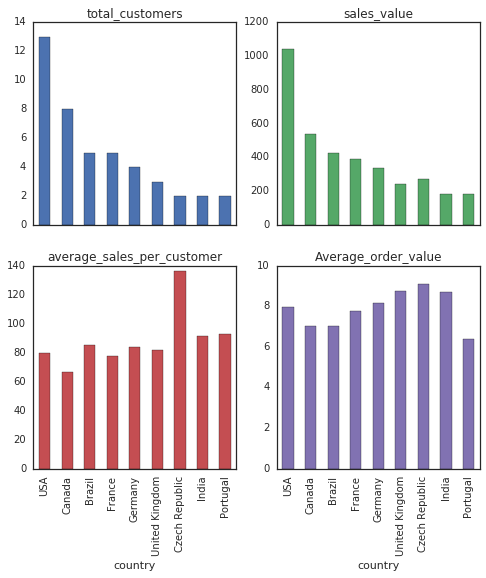

In [9]:
(purchases_per_country.loc[purchases_per_country["country"]!="Other"]
 .plot(kind='bar',
       x='country',
       subplots = True,
       figsize=(8,8),
       layout = (2,2),
       legend = False
      )
)
sns.set_style('white')

Interpretations: 

    most customers and sales are in the US
    Czech Republic has high sales per customers, though low total sales
    the remaining countries are similar
    Portugal is the worst
    

# Should the Chinook store buy full albumns or popular tracks only

In [63]:

q = """
WITH
total_tracks AS
    (
        SELECT t.album_id, COUNT(t.track_id) tracks
        FROM track t
        GROUP BY t.album_id
        ORDER BY t.album_id
    ),
tracks_per_invoice AS
    (
        SELECT
            il.invoice_id,
            COUNT(t.track_id) tracks,
            t.album_id
        FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        GROUP BY il.invoice_id, t.album_id
    ),
full_album AS
    (
        SELECT ti.invoice_id, ti.tracks purchased_tracks, tt.tracks, "albumn" purchase_type
        FROM total_tracks tt
        INNER JOIN tracks_per_invoice ti ON ti.album_id = tt.album_id
        WHERE tt.tracks=ti.tracks
        ORDER BY ti.invoice_id
    ),
tracks_only AS
    (
        SELECT ti.invoice_id, ti.tracks purchased_tracks, tt.tracks, "partial" purchase_type
        FROM total_tracks tt
        INNER JOIN tracks_per_invoice ti ON ti.album_id = tt.album_id
        WHERE tt.tracks!=ti.tracks
        ORDER BY ti.invoice_id
    ),
joined_tables AS
    (
        SELECT * FROM full_album
        UNION
        SELECT * FROM tracks_only
    )
SELECT
    COUNT(invoice_id) invoices,
    CAST(COUNT(invoice_id) as float) / CAST((SELECT COUNT(*) FROM joined_tables) as float) * 100 invoice_percentage,
    SUM(purchased_tracks) purchased_tracks,
    CAST(SUM(purchased_tracks) as float) / CAST((SELECT SUM(purchased_tracks) FROM joined_tables) as float) * 100 track_percentage
FROM joined_tables
GROUP BY purchase_type
;
"""

run_query(q)

,invoices,invoice_percentage,purchased_tracks,track_percentage
0,200,7.870917,1562,37.014218
1,2341,92.129083,2658,62.985782
